## Project: Prediction of sex based on heights using machine learning
- **Source**: dslabs
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model guide

In [28]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, 
                             f1_score,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [29]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('heights.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1050 non-null   int64  
 1   sex         1050 non-null   object 
 2   height      1050 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.7+ KB


In [30]:
# 1.2 Get a sample
display(df_raw.sample(10, random_state=2024))

,Unnamed: 0,sex,height
85,86,Male,70.000000
531,532,Male,69.000000
216,217,Male,68.000000
957,958,Male,72.834646
438,439,Male,69.000000
176,177,Female,66.000000
141,142,Female,65.000000
195,196,Female,70.000000
467,468,Male,66.000000
470,471,Male,70.000000


### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [31]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'sex':'target'})
    .astype({'target':'category'})
    .iloc[:,1:]
)

In [32]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   target  1050 non-null   category
 1   height  1050 non-null   float64 
dtypes: category(1), float64(1)
memory usage: 9.5 KB


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [82]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2, 
                                     stratify=df['target'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 362 to 686
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   target  840 non-null    category
 1   height  840 non-null    float64 
dtypes: category(1), float64(1)
memory usage: 14.1 KB


In [34]:
# 3.1 Get numerical and categorical summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
height,840.0,68.347764,4.211153,50.0,66.0,68.5,71.0,82.677165


,count,unique,top,freq
target,840,2,Male,650


In [35]:
# 3.2 Get the summary for the response variable
table = pd.concat(
    [df_train['target'].value_counts(),
     df_train['target'].value_counts(normalize=True)],axis=1
)
display(table)
print(f'Sum:{df_train['target'].count()}')

,count,proportion
target,,
Male,650,0.77381
Female,190,0.22619


Sum:840


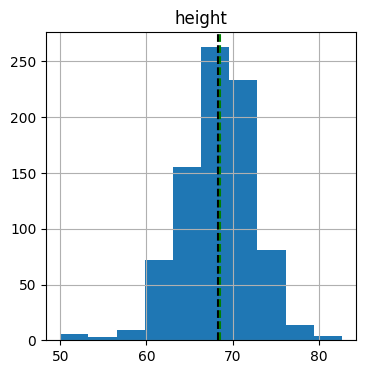

In [36]:
# 3.3 Perform univariate analysis on numerical variables
fig, ax = plt.subplots(figsize=(4,4))
df_train.hist(figsize=(6,6), ax=ax)
ax.axvline(x=df_train['height'].mean(), color='k', linestyle='--')
ax.axvline(x=df_train['height'].median(), color='g', linestyle='--')
plt.show()

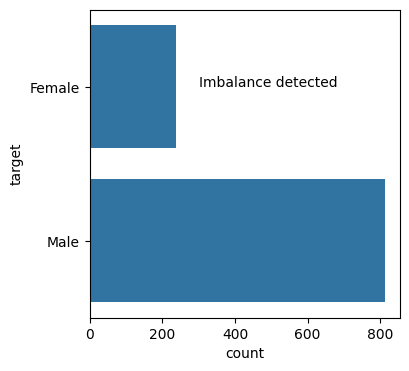

In [37]:
# 3.4 Perform univariate analysis for categorical variables
fig, ax = plt.subplots(figsize=(4,4))
sns.countplot(data=df, y='target', ax=ax)
ax.annotate(text='Imbalance detected', xy=(300,0))
plt.show()

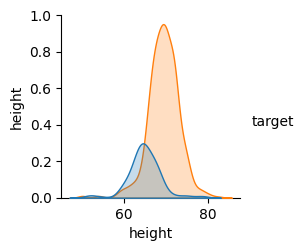

In [38]:
# 3.5 Perform bivariate analysis for numerical values, using target
sns.pairplot(data=df_train, hue='target')
plt.show()

,

In [54]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)


In [55]:
# 4.2 Encode the response 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [56]:
# 4.1 Create a naive model, by guessing the outcome, then evaluate
y_naive = np.random.choice(
    df_train['target'].unique().tolist(), size=len(df_train)
)
y_naive_enc = label_encoder.transform(y_naive)
print(f'Accuracy: {accuracy_score(y_train_enc, y_naive_enc):.2f}')

Accuracy: 0.56


In [57]:
# 4.2 Create a model based on confidence intervals
# 4.2.1 Get the mean and standard deviation
df_train.groupby('target', observed=False)['height'].agg(['mean','std'])

,mean,std
target,,
Female,64.847822,3.899699
Male,69.370824,3.723219


In [66]:
# 4.2.2 Create a rule that covers the mean plus two sds, then evaluate
y_interval = (
    df_train['height'].apply(lambda x: 'Male' if x >= 62 else 'Female')
    .tolist()
)
y_interval_enc = label_encoder.transform(y_interval)
print(f'Accuracy: {accuracy_score(y_train_enc, y_interval_enc):.3f}')
print(f'f1 score: {f1_score(y_train_enc, y_interval_enc):.3f}')

Accuracy: 0.779
f1 score: 0.871


In [62]:
# 4.3 Create a model that finds the best cutoff for the accuracy
# 4.3.1 Create a table and get the accuracies
mytable = pd.DataFrame({'cutoff':[62],'accuracy':[0.779]})
for i in range(63,76):
    y_temp = (
        df_train['height'].apply(lambda x: 'Male' if x >= i else 'Female')
        .tolist()
    )
    y_temp_enc = label_encoder.transform(y_temp)
    metric = round(accuracy_score(y_train_enc, y_temp_enc),3)
    new_row = pd.DataFrame({'cutoff':[i],'accuracy':[metric]})
    mytable = pd.concat([new_row, mytable])
mytable.reset_index(drop=True)


,cutoff,accuracy
0,75,0.273
1,74,0.302
2,73,0.330
3,72,0.427
4,71,0.487
5,70,0.592
6,69,0.662
7,68,0.730
8,67,0.783
9,66,0.831


In [63]:
# 4.3.2 Apply the best cutoff
y_cutoff = (
    df_train['height'].apply(lambda x: 'Male' if x >= 65 else 'Female')
    .tolist()
)
y_cutoff_enc = label_encoder.transform(y_cutoff)
print(f'Accuracy: {accuracy_score(y_train_enc, y_cutoff_enc):.3f}')

Accuracy: 0.837


In [64]:
pred = pd.DataFrame({'pred':y_cutoff})
display(pd.crosstab(y_train,pred['pred']))
display(pd.crosstab(y_train,pred['pred'], normalize='index'))

pred,Female,Male
target,,
Female,97,93
Male,44,606


pred,Female,Male
target,,
Female,0.510526,0.489474
Male,0.067692,0.932308


In [79]:
# 4.4 Create a model that finds the best cutoff for the balanced metric
mytable = pd.DataFrame({'cutoff':[],'f1_score':[],'accuracy':[]})
for i in range(60,76):
    y_bal = (
        df_train['height'].apply(lambda x: 'Male' if x >= i else 'Female')
        .tolist()
    )
    y_bal_enc = label_encoder.transform(y_bal)
    metric_f = round(f1_score(y_train_enc, y_bal_enc),3)
    metric_a = round(accuracy_score(y_train_enc, y_bal_enc),3)
    new_row = pd.DataFrame({'cutoff':[i],'f1_score':[metric_f],'accuracy':[metric_a]})
    mytable = pd.concat([new_row, mytable])
mytable.reset_index(drop=True)

,cutoff,f1_score,accuracy
0,75.0,0.123,0.273
1,74.0,0.193,0.302
2,73.0,0.248,0.330
3,72.0,0.424,0.427
4,71.0,0.514,0.487
5,70.0,0.650,0.592
6,69.0,0.731,0.662
7,68.0,0.801,0.730
8,67.0,0.851,0.783
9,66.0,0.891,0.831


In [73]:
y_interval = (
    df_train['height'].apply(lambda x: 'Male' if x >= 63 else 'Female')
    .tolist()
)
y_interval_enc = label_encoder.transform(y_interval)
print(f'Accuracy: {accuracy_score(y_train_enc, y_interval_enc):.3f}')
print(f'f1 score: {f1_score(y_train_enc, y_interval_enc):.3f}')

Accuracy: 0.790
f1 score: 0.876
